<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Compare-Losses" data-toc-modified-id="Compare-Losses-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Compare Losses</a></span><ul class="toc-item"><li><span><a href="#Imports-&amp;-Constants" data-toc-modified-id="Imports-&amp;-Constants-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports &amp; Constants</a></span></li><li><span><a href="#Loading-data-&amp;-processing-pipeline" data-toc-modified-id="Loading-data-&amp;-processing-pipeline-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Loading data &amp; processing pipeline</a></span></li><li><span><a href="#Creating-testing-function-(evaluates-the-distances-generated-by-the-network)" data-toc-modified-id="Creating-testing-function-(evaluates-the-distances-generated-by-the-network)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Creating testing function (evaluates the distances generated by the network)</a></span></li><li><span><a href="#Training-&amp;-comparing-the-distance-models" data-toc-modified-id="Training-&amp;-comparing-the-distance-models-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Training &amp; comparing the distance models</a></span><ul class="toc-item"><li><span><a href="#Instantiating-model,-loss-and-optimizer" data-toc-modified-id="Instantiating-model,-loss-and-optimizer-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Instantiating model, loss and optimizer</a></span></li><li><span><a href="#Training-&amp;-Validation-loops" data-toc-modified-id="Training-&amp;-Validation-loops-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Training &amp; Validation loops</a></span></li></ul></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Plotting</a></span><ul class="toc-item"><li><span><a href="#Evolution-of-performance-during-training" data-toc-modified-id="Evolution-of-performance-during-training-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Evolution of performance during training</a></span></li></ul></li></ul></li></ul></div>

# Compare Losses
---
In this notebook, we will train 3 models to perform sequence similarity detection:
 - Siamese Network trained with *Contrastive Loss*
 - Siamese Network trained with *Triplet Loss*
 - Siamese Network trained with *Quadruplet Loss*

## Imports & Constants

In [1]:
import os
import sys
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Used to import libraries from an absolute path starting with the project's root
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime
import importlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.linear_model import LogisticRegression
import sklearn.metrics

# Local imports
from src.dataset.multiLossSimilarityVectorizedDataset import MultiLossSimilarityVectorizedDataset

In [2]:
BATCH_SIZE = 64
EMBEDDING_DIM = 40
EPOCHS = 25
TRAIN = 0.8
TEST = 0.1
VAL = 0.1
SHUFFLE = True
SEED = 42
LR = 1e-3
TO_SAVE = True

torch.manual_seed(SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")

Device used: cuda:0


## Loading data & processing pipeline
We are loading the PyTorch compatible Dataset class and create 3 dataloaders, one per set of data (train, val, test)

In [3]:
def padding_collate(batch):
    """
        Used as a PyTorch collate_fn function in PyTorch dataloaders. 
        Given a batch of vectors of shape (word_count, word_size), 
        make the word_count of each sequence uniform by doing right-side 0 padding.
        
        /!\ The sequences size between batches may vary /!\
    """
    
    max_shape_val = max(
        [
                #b[0] to get X, b[0][0] to get the first sentence of every X, b[0][1] to get the second sentence of every X
            max(b[0][0].shape[0], b[0][1].shape[0]) for b in batch
        ]
    )
    
    X1 = []
    X2 = []
    X3 = []
    X4 = []
    y = [] 
        
    for i in range(len(batch)):
        
        #batch[i][0] is X, batch[i][1] is y
        x1 = batch[i][0][0]
                    
        if x1.shape[0] < max_shape_val:            
            to_be_padded_shape = (max_shape_val - x1.shape[0], x1.shape[1])
            padding = torch.zeros(to_be_padded_shape)
            x1 = torch.cat((x1, padding), dim=0)
                
        x2 = batch[i][0][1]
        
        if x2.shape[0] < max_shape_val:            
            to_be_padded_shape = (max_shape_val - x2.shape[0], x2.shape[1])
            padding = torch.zeros(to_be_padded_shape)
            x2 = torch.cat((x2, padding), dim=0)
        
        x3 = batch[i][0][2]
        
        if x3.shape[0] < max_shape_val:            
            to_be_padded_shape = (max_shape_val - x3.shape[0], x3.shape[1])
            padding = torch.zeros(to_be_padded_shape)
            x3 = torch.cat((x3, padding), dim=0)
        
        x4 = batch[i][0][3]
        
        if x4.shape[0] < max_shape_val:            
            to_be_padded_shape = (max_shape_val - x4.shape[0], x4.shape[1])
            padding = torch.zeros(to_be_padded_shape)
            x4 = torch.cat((x4, padding), dim=0)
    
        X1.append(x1)
        X2.append(x2)
        X3.append(x3)
        X4.append(x4)
                
        y.append([batch[i][1]])
    
    X1 = torch.stack(X1)
    X2 = torch.stack(X2)
    X3 = torch.stack(X3)
    X4 = torch.stack(X4)
    
    return (X1, X2, X3, X4), torch.FloatTensor(y)


In [4]:
dataset = MultiLossSimilarityVectorizedDataset()

# Data preparation 
dataset_size = len(dataset)#1280
indices = list(range(dataset_size))

val_split = int(np.floor(VAL * dataset_size))
test_split = int(np.floor(TEST * dataset_size))

if SHUFFLE:
    np.random.seed(SEED)
    np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[val_split+test_split:], indices[:val_split], indices[val_split:val_split+test_split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

num_train_batch = int(np.ceil(TRAIN * dataset_size / BATCH_SIZE))
num_val_batch = int(np.ceil(VAL * dataset_size / BATCH_SIZE))
num_test_batch = int(np.ceil(TEST * dataset_size / BATCH_SIZE))

print("Creating dataloaders..")

dataloader_train = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    batch_size = BATCH_SIZE,
    collate_fn = padding_collate,
    sampler = train_sampler
)

dataloader_val = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    batch_size = BATCH_SIZE,
    collate_fn = padding_collate,
    sampler = val_sampler
)

dataloader_test = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    collate_fn = padding_collate,
    sampler = test_sampler
)

Creating dataloaders..


In [5]:
print("Creating distance dataloaders...")
dist_dataloader_train = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    batch_size = 128,
    collate_fn = padding_collate,
    sampler = train_sampler
)

dist_dataloader_val = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    batch_size=128,
    collate_fn = padding_collate,
    sampler = val_sampler
)

dist_dataloader_test = torch.utils.data.dataloader.DataLoader(
    dataset = dataset,
    batch_size=128,
    collate_fn = padding_collate,
    sampler = test_sampler
)

Creating distance dataloaders...


## Creating testing function (evaluates the distances generated by the network)

In [6]:
import torch.nn.functional as F

In [7]:
X_c = None
y_c = None
def model_and_titles_to_distance_dataset(models, dataloader):
    """
    Given a similarity learning model and a dataloader, transforms the data of the dataloader in the shape of a distance dataset.
    The distances are computed using the model. We then use the target variables to train a linear model to classify the distances
    to 2 different classes: similar or dissimilar.
    """

    model_c, model_t, model_q = models

    global X_c;
    X_c = []
    global y_c;
    y_c = []
    
    X_t = []
    y_t = []
    
    X_q = []
    y_q = []
    
    n = 1
    
    total_duration = 0
    total_steps = len(dataloader)
    
    model_c.eval(); model_t.eval(); model_q.eval()
    
    t0 = time.time()
    
    for local_batch, local_labels in dataloader:
        model_c.zero_grad()
        model_t.zero_grad()
        model_q.zero_grad()
        local_batch_X1, local_batch_X2, local_batch_X3, local_batch_X4, local_labels = \
            local_batch[0].to(device), local_batch[1].to(device), local_batch[2].to(device), local_batch[3].to(device), local_labels.to(device)

        r = np.random.random()
        if (r > 0.5):
            out1, out2 = siameseModel(local_batch_X1, local_batch_X2) #positive duplicates
            local_labels_c = local_labels
        else:
            out1, out2 = siameseModel(local_batch_X1, local_batch_X3) #negative duplicates
            local_labels_c = local_labels - 1
                
        dist = F.pairwise_distance(out1, out2, 2)

        with torch.no_grad():
            # Transfering distances and labels to cpu
            distances_cpu = dist.cpu().numpy().reshape(-1, 1)
            labels = torch.flatten(local_labels_c).cpu().numpy().reshape(-1, 1)
            # Fitting logreg
            X_c.append(distances_cpu)
            y_c.append(labels)
        
        out1, out2, out3 = tripletModel(local_batch_X1, local_batch_X2, local_batch_X3)
        
        dist1 = F.pairwise_distance(out1, out2, 2)
        dist2 = F.pairwise_distance(out1, out3, 2)
        with torch.no_grad():
            # Transfering distances and labels to cpu
            distances_cpu = dist1.cpu().numpy().reshape(-1, 1)
            labels = torch.flatten(local_labels).cpu().numpy().reshape(-1, 1)
            # Fitting logreg
            X_t.append(distances_cpu)
            y_t.append(labels)
            
            # Transfering distances and labels to cpu
            distances_cpu = dist2.cpu().numpy().reshape(-1, 1)
            labels = torch.flatten(local_labels - 1).cpu().numpy().reshape(-1, 1)
            # Fitting logreg
            X_t.append(distances_cpu)
            y_t.append(labels)

        out1, out2, out3, _ = quadrupletModel(local_batch_X1, local_batch_X2, local_batch_X3, local_batch_X4)
        dist1 = F.pairwise_distance(out1, out2, 2)
        dist2 = F.pairwise_distance(out1, out3, 2)
        with torch.no_grad():
            # Transfering distances and labels to cpu
            distances_cpu = dist1.cpu().numpy().reshape(-1, 1)
            labels = torch.flatten(local_labels).cpu().numpy().reshape(-1, 1)
            # Fitting logreg
            X_q.append(distances_cpu)
            y_q.append(labels)
            
            # Transfering distances and labels to cpu
            distances_cpu = dist2.cpu().numpy().reshape(-1, 1)
            labels = torch.flatten(local_labels - 1).cpu().numpy().reshape(-1, 1)
            # Fitting logreg
            X_q.append(distances_cpu)
            y_q.append(labels)    
            
        
        duration = time.time() - t0
        
        total_duration += duration
        
        per_step_mean_duration = total_duration / n
        rest_of_time = per_step_mean_duration * (total_steps)
        
        n+=1
        print(f"\r{n}-{total_steps} (ETA: {total_duration}/{rest_of_time}s)", end="")
        
        t0 = time.time()
        
    model_c.train();model_t.train();model_q.train()
    
    X_c = np.concatenate(np.concatenate(np.array(X_c).flatten().reshape(-1, 1)))
    X_t = np.concatenate(np.concatenate(np.array(X_t).flatten().reshape(-1, 1)))
    X_q = np.concatenate(np.concatenate(np.array(X_q).flatten().reshape(-1, 1)))
    
    y_c = np.concatenate(np.array(y_c).flatten())
    y_t = np.concatenate(np.array(y_t).flatten())
    y_q = np.concatenate(np.array(y_q).flatten())
        
    return (X_c, X_t, X_q), (y_c, y_t, y_q)


In [8]:
def get_metrics(models):
    # Generating datasets of distances
    print("\nGenerating training dataset...")
    X_train, y_train = model_and_titles_to_distance_dataset(models, dist_dataloader_train)

    print("\nGenerating test dataset...")
    X_test, y_test = model_and_titles_to_distance_dataset(models, dist_dataloader_test)

    print("\nGenerating validation dataset...")
    X_val, y_val = model_and_titles_to_distance_dataset(models, dist_dataloader_val)
    
    # Classifying the distances
    
    (X_train_c, X_train_t, X_train_q), (y_train_c, y_train_t, y_train_q) = X_train, y_train

    (X_test_c, X_test_t, X_test_q), (y_test_c, y_test_t, y_test_q) = X_test, y_test

    (X_val_c, X_val_t, X_val_q), (y_val_c, y_val_t, y_val_q) = X_val, y_val
    
    logreg = LogisticRegression()
    logreg.fit(X_train_c, y_train_c)

    preds_test_c = logreg.predict(X_test_c)
    
    train_acc = logreg.score(X_train_c, y_train_c)
    val_acc = logreg.score(X_val_c, y_val_c)
    test_acc_c = logreg.score(X_test_c, y_test_c)
    auc_c = sklearn.metrics.roc_auc_score(preds_test_c, y_test_c)
    
    print(f"\nFinal perfs (Contrastive): {train_acc} - {val_acc} - {test_acc_c} - {auc_c}")

    logreg = LogisticRegression()
    logreg.fit(X_train_t, y_train_t)

    preds_test_t = logreg.predict(X_test_t)

    train_acc = logreg.score(X_train_t, y_train_t)
    val_acc = logreg.score(X_val_t, y_val_t)
    test_acc_t = logreg.score(X_test_t, y_test_t)
    auc_t = sklearn.metrics.roc_auc_score(preds_test_t, y_test_t)

    print(f"\nFinal perfs (Triplet): {train_acc} - {val_acc} - {test_acc_t} - {auc_t}")

    logreg = LogisticRegression()
    logreg.fit(X_train_q, y_train_q)

    preds_test_q = logreg.predict(X_test_q)

    train_acc = logreg.score(X_train_q, y_train_q)
    val_acc = logreg.score(X_val_q, y_val_q)
    test_acc_q = logreg.score(X_test_q, y_test_q)
    auc_q = sklearn.metrics.roc_auc_score(preds_test_q, y_test_q)

    print(f"\nFinal perfs (Quadruplet): {train_acc} - {val_acc} - {test_acc_q} - {auc_q}")
    
    return (auc_c, test_acc_c), (auc_t, test_acc_t), (auc_q, test_acc_q)

## Training & comparing the distance models

### Instantiating model, loss and optimizer

In [9]:
import src.model.contrastiveModel as net
importlib.reload(net)
from src.model.losses import ContrastiveLoss, TripletLoss, QuadrupletLoss

In [10]:
siameseModel = net.SiameseLSTM(embedding_dim = EMBEDDING_DIM)
siameseModel.cuda()
siameseModel.train()

tripletModel = net.TripletLSTM(embedding_dim = EMBEDDING_DIM)
tripletModel.cuda()
tripletModel.train()

quadrupletModel = net.QuadrupletLSTM(embedding_dim = EMBEDDING_DIM)
quadrupletModel.cuda()
quadrupletModel.train()

contrastive_loss = ContrastiveLoss()
optimizer_c = optim.AdamW(siameseModel.parameters(), lr=LR)

triplet_loss = TripletLoss()
optimizer_t = optim.AdamW(tripletModel.parameters(), lr=LR)

quadruplet_loss = QuadrupletLoss()
optimizer_q = optim.AdamW(quadrupletModel.parameters(), lr=LR)

### Training & Validation loops

In [11]:
min_val_loss = np.inf
siamese_metrics = []
triplet_metrics = []
quadruplet_metrics = []
for i in range(EPOCHS):

    print(f"Epochs {i}")
    n = 1
    
    total_loss_c = 0
    total_loss_t = 0
    total_loss_q = 0
    
    total_duration = 0
    t0 = time.time()
    total_timesteps = len(dataloader_train)

    for local_batch, local_labels in dataloader_train:
        siameseModel.zero_grad()
        tripletModel.zero_grad()
        quadrupletModel.zero_grad()
        
        local_batch_X1, local_batch_X2, local_batch_X3, local_batch_X4, local_labels = \
            local_batch[0].to(device), local_batch[1].to(device), local_batch[2].to(device), local_batch[3].to(device), local_labels.to(device)
              
        r = np.random.random()
        if (r > 0.5):
            out1, out2 = siameseModel(local_batch_X1, local_batch_X2) #positive duplicates
        else:
            out1, out2 = siameseModel(local_batch_X1, local_batch_X3) #negative duplicates
            local_labels = local_labels - 1
                
        dist = F.pairwise_distance(out1, out2, 2)
        # Compute the loss, gradients, and update the parameters by
        #loss = loss_function(preds, local_labels)
        loss_c = contrastive_loss(dist, local_labels)
        loss_c.backward()
        optimizer_c.step()
        
        out1, out2, out3 = tripletModel(local_batch_X1, local_batch_X2, local_batch_X3)
        
        loss_t = triplet_loss(out1, out2, out3)
        loss_t.backward()
        optimizer_t.step()

        out1, out2, out3, out4 = quadrupletModel(local_batch_X1, local_batch_X2, local_batch_X3, local_batch_X4)
        
        loss_q = quadruplet_loss(out1, out2, out3, out4)
        loss_q.backward()
        optimizer_q.step()
        
        # Statistics to follow progress
        total_loss_c += loss_c.item()
        total_loss_t += loss_t.item()
        total_loss_q += loss_q.item()
        duration = time.time() - t0
        total_duration += duration
        total_duration = round(total_duration, 2)

        estimated_duration_left = round((total_duration / n) * (total_timesteps), 2)

        print(f"\r Epochs {i} - Loss c: {total_loss_c/n} - Loss t: {total_loss_t/n} - Loss q: {total_loss_q/n} - Batch: {n}/{num_train_batch} - Dur: {total_duration}s/{estimated_duration_left}s", end="")
        n+=1
        t0 = time.time()

    print("\n")

    # End of epochs validation

    n = 1
    total_loss_c = 0
    total_loss_t = 0
    total_loss_q = 0
    
    with torch.no_grad():
        siameseModel.eval()
        tripletModel.eval()
        quadrupletModel.eval()
        for local_batch, local_labels in dataloader_val:
            local_batch_X1, local_batch_X2, local_batch_X3, local_batch_X4, local_labels = \
                local_batch[0].to(device), local_batch[1].to(device), local_batch[2].to(device), local_batch[3].to(device), local_labels.to(device)

            if (np.random.random() > 0.5):
                out1, out2 = siameseModel(local_batch_X1, local_batch_X2) #positive duplicates
            else:
                out1, out2 = siameseModel(local_batch_X1, local_batch_X3) #negative duplicates
                local_labels = local_labels - 1

            dist = torch.dist(out1, out2, 2)
            loss_c = contrastive_loss(dist, local_labels)

            out1, out2, out3 = tripletModel(local_batch_X1, local_batch_X2, local_batch_X3)
            loss_t = triplet_loss(out1, out2, out3)

            out1, out2, out3, out4 = quadrupletModel(local_batch_X1, local_batch_X2, local_batch_X3, local_batch_X4)
            loss_q = quadruplet_loss(out1, out2, out3, out4)

            # Statistics to follow progress
            total_loss_c += loss_c.item()
            total_loss_t += loss_t.item()
            total_loss_q += loss_q.item()
            print(f"\r Epochs {i} - Val_Loss c: {total_loss_c/n} - Val_Loss t: {total_loss_t/n} - Val_Loss q: {total_loss_q/n} - Batch: {n}/{num_train_batch} - Dur: {total_duration}s/{estimated_duration_left}s", end="")
        
            n+=1

        siameseMetrics, tripletMetrics, quadrupletMetrics = get_metrics((siameseModel, tripletModel, quadrupletModel))
        
        siamese_metrics.append(siameseMetrics)
        triplet_metrics.append(tripletMetrics)
        quadruplet_metrics.append(quadrupletMetrics)
        
        siameseModel.train()
        tripletModel.train()
        quadrupletModel.train()
    print("\n---")

Epochs 0
 Epochs 0 - Loss c: 0.09368274624874386 - Loss t: 1.1175317569273462 - Loss q: 1.2667431502831583 - Batch: 1866/1866 - Dur: 474.64s/474.64s

 Epochs 0 - Val_Loss c: 2.5127090220777397 - Val_Loss t: 0.6637175023301035 - Val_Loss q: 0.8525397288493621 - Batch: 234/1866 - Dur: 474.64s/474.64s
Generating training dataset...
934-933 (ETA: 183.91389298439026/183.91389298439026s)
Generating test dataset...
118-117 (ETA: 22.609503030776978/22.609503030776978s)
Generating validation dataset...
118-117 (ETA: 22.162713766098022/22.162713766098022s)
Final perfs (Contrastive): 0.778738977146159 - 0.7843360578855688 - 0.779646254857296 - 0.7793530298138739

Final perfs (Triplet): 0.7802714992756111 - 0.7804167224976551 - 0.7783733083210506 - 0.7784997214352986

Final perfs (Quadruplet): 0.8074884223396505 - 0.8086225378534102 - 0.8056746616642101 - 0.8058057233330127

---
Epochs 1
 Epochs 1 - Loss c: 0.08069438234846021 - Loss t: 0.5252201445600355 - Loss q: 0.7021155818130936 - Batch: 1866

 Epochs 9 - Val_Loss c: 1.6117471431055639 - Val_Loss t: 0.17330110875459817 - Val_Loss q: 0.21182861879595324 - Batch: 234/1866 - Dur: 451.16s/451.16s
Generating training dataset...
934-933 (ETA: 174.79841995239258/174.79841995239258s)
Generating test dataset...
118-117 (ETA: 21.59521770477295/21.59521770477295s)s)
Generating validation dataset...
118-117 (ETA: 21.583269596099854/21.583269596099854s)
Final perfs (Contrastive): 0.8947668137776251 - 0.892737505024789 - 0.8869757470186252 - 0.8868692083271097

Final perfs (Triplet): 0.9040666270276607 - 0.9006766715797937 - 0.8946804234222163 - 0.8946863830790868

Final perfs (Quadruplet): 0.9191908618134008 - 0.9149135736299076 - 0.9131381481977757 - 0.9131485795813734

---
Epochs 10
 Epochs 10 - Loss c: 0.04867839950385393 - Loss t: 0.12491810774791982 - Loss q: 0.16339773529020538 - Batch: 1866/1866 - Dur: 454.64s/454.64ss

 Epochs 10 - Val_Loss c: 1.938619984393446 - Val_Loss t: 0.15027622965315723 - Val_Loss q: 0.18917641546736416 -

934-933 (ETA: 174.74150967597961/174.74150967597961s)
Generating test dataset...
118-117 (ETA: 21.692994594573975/21.692994594573975s)
Generating validation dataset...
118-117 (ETA: 21.53139352798462/21.53139352798462s)))
Final perfs (Contrastive): 0.9245211915150195 - 0.9187994104247622 - 0.9098217874849256 - 0.9089889170380587

Final perfs (Triplet): 0.9274899297384663 - 0.9179284470052258 - 0.9163205145383894 - 0.9163214189939688

Final perfs (Quadruplet): 0.9401688286673757 - 0.9324333377998124 - 0.9266715797936487 - 0.92667159703016

---
Epochs 19
 Epochs 19 - Loss c: 0.03820941434216876 - Loss t: 0.06036873654305679 - Loss q: 0.08223842200598533 - Batch: 1866/1866 - Dur: 455.81s/455.81s1s

 Epochs 19 - Val_Loss c: 1.594570608984711 - Val_Loss t: 0.1336899823230556 - Val_Loss q: 0.14256109133299089 - Batch: 234/1866 - Dur: 455.81s/455.81s1s
Generating training dataset...
934-933 (ETA: 182.41469144821167/182.41469144821167s)
Generating test dataset...
118-117 (ETA: 22.5427219867706

In [17]:
siamese_auc, siamese_test_acc = zip(*siamese_metrics)
triplet_auc, triplet_test_acc = zip(*triplet_metrics)
quadruplet_auc, quadruplet_test_acc = zip(*quadruplet_metrics)

## Plotting
Even if the results are pretty straightforward, we will print the training results of the 3 different algorithms used in this notebook.
### Evolution of performance during training

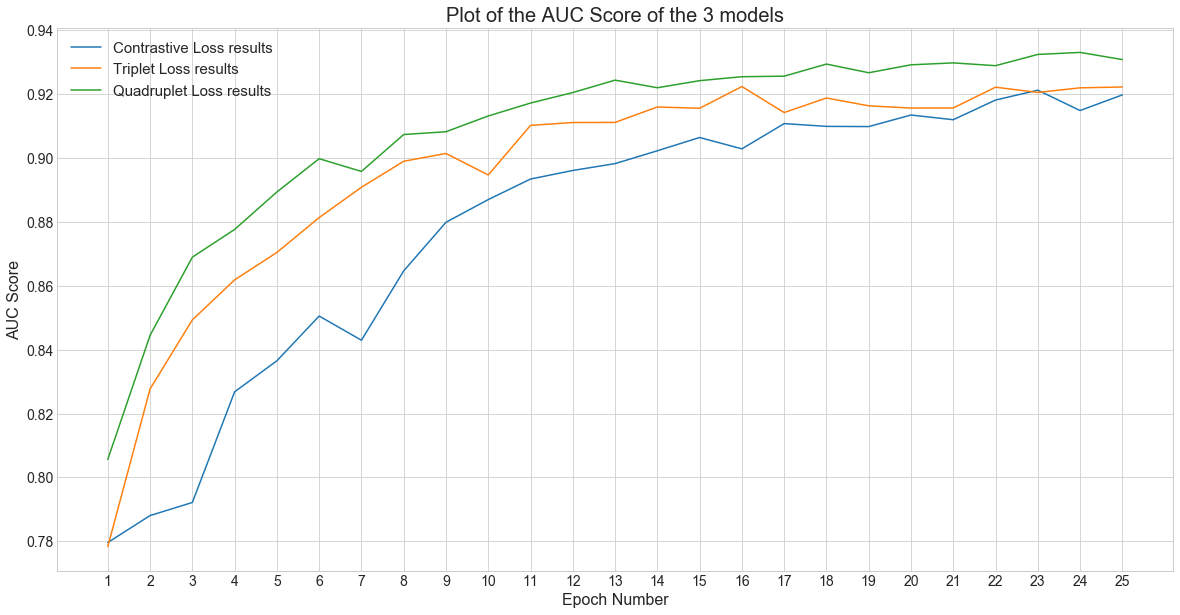

In [47]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20, 10))

plt.ylabel("AUC Score", fontsize=16)
plt.xlabel("Epoch Number", fontsize=16)
plt.title("Plot of the AUC Score of the 3 models", fontsize=20)
plt.tick_params(labelsize=14)

indexes = [i+1 for i in range(len(siamese_test_acc))]
plt.xticks(indexes)

plt.plot(indexes, siamese_test_acc, label="Contrastive Loss results")
plt.plot(indexes, triplet_test_acc, label="Triplet Loss results")
plt.plot(indexes, quadruplet_test_acc, label="Quadruplet Loss results")
plt.legend(prop={'size': 15})
plt.show()